In [1]:
!lscpu |grep 'Nome do modelo'

Nome do modelo:                         AMD Ryzen 7 5700X 8-Core Processor


In [2]:
import pandas as pd
import numpy as np
import operator

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Nov 20 15:49:36 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.57.01              Driver Version: 565.57.01      CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060        Off |   00000000:07:00.0  On |                  N/A |
| 53%   47C    P3             58W /  170W |    1190MiB /  12288MiB |     18%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
import gc
from sys import getsizeof

def split_into_nibbles(array):
    array = np.array(array)
    shape = list(array.shape)
    shape[-1] *= 2
    array2 = (array.reshape(-1, 1) & np.array([0xF0, 0x0F], dtype=np.uint8)) >> np.array([4, 0], dtype=np.uint8)
    return array2.reshape(shape)

def create_dataset(dataset, ypsilons, look_back=44, size_bytes=58):
    X, Y = [], []
    look_back += 1

    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back)]
        X.append(a)
        # Y.append(ypsilons.iloc[i+look_back][0]) #verificar se tem pacotes maliciosos
        if np.all(np.array(ypsilons[i:(i+look_back)])== 0):
          Y.append(0)
        else:
          Y.append(1)

    features=[]
    print(len(X))
    for i in range(len(X)):
      deltaX=[]
      e=0
      for e in range(look_back-1):  
        e+=1
        b = split_into_nibbles([((a_i - b_i) % 256) for a_i, b_i in list(zip(X[i][e][:size_bytes], X[i][e-1][:size_bytes]))])       
        deltaX.append(b)
      features.append(np.array(deltaX, dtype=np.uint8))
      # if i == 1490000:
      #   break;
      if not i % 100000:
        gc.collect()
        print(i)
    print(len(features))
    return np.array(features), np.array(Y)

In [4]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, average_precision_score
from scipy.stats import ks_2samp
import scikitplot as skplt


import matplotlib.pyplot as plt
import sklearn

from scipy.stats import ks_2samp
from sklearn.metrics import roc_curve, auc


def extract_final_losses(history):
    """Função para extrair o melhor loss de treino e validação.
    
    Argumento(s):
    history -- Objeto retornado pela função fit do keras.
    
    Retorno:
    Dicionário contendo o melhor loss de treino e de validação baseado 
    no menor loss de validação.
    """
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    idx_min_val_loss = np.argmin(val_loss)
    return {'train_loss': train_loss[idx_min_val_loss], 'val_loss': val_loss[idx_min_val_loss]}

def plot_training_error_curves(history):
    """Função para plotar as curvas de erro do treinamento da rede neural.
    
    Argumento(s):
    history -- Objeto retornado pela função fit do keras.
    
    Retorno:
    A função gera o gráfico do treino da rede e retorna None.
    """
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    fig, ax = plt.subplots()
    ax.plot(train_loss, label='Train')
    ax.plot(val_loss, label='Validation')
    ax.set(title='Training and Validation Error Curves', xlabel='Epochs', ylabel='Loss (MSE)')
    ax.legend()
    plt.show()

def compute_performance_metrics(y, y_pred_class, y_pred_scores=None):
    accuracy = accuracy_score(y, y_pred_class)
    recall = recall_score(y, y_pred_class)
    precision = precision_score(y, y_pred_class)
    f1 = f1_score(y, y_pred_class)
    performance_metrics = (accuracy, recall, precision, f1)
    if y_pred_scores is not None:
        skplt.metrics.plot_ks_statistic(y, y_pred_scores)
        plt.savefig("ks_plot.png")
        plt.show()
        y_pred_scores = y_pred_scores[:, 1]
        auroc = roc_auc_score(y, y_pred_scores)
        aupr = average_precision_score(y, y_pred_scores)
        performance_metrics = performance_metrics + (auroc, aupr)
    return performance_metrics

def print_metrics_summary(accuracy, recall, precision, f1, auroc=None, aupr=None):
    print()
    print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy))
    print("{metric:<18}{value:.4f}".format(metric="Recall:", value=recall))
    print("{metric:<18}{value:.4f}".format(metric="Precision:", value=precision))
    print("{metric:<18}{value:.4f}".format(metric="F1:", value=f1))
    if auroc is not None:
        print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=auroc))
    if aupr is not None:
        print("{metric:<18}{value:.4f}".format(metric="AUPR:", value=aupr))

# Load Data

In [5]:
path = "/home/pedro/projetoDL/dataset/processado/"
log_path_tmp = "/home/pedro/projetoDL/log"

In [6]:
Y = np.load(path + 'Y_test_Driving_NewApproach_Injected_v2.npz')
Y= Y.f.arr_0

X = np.load(path + 'X_test_Driving_NewApproach_Injected_v2.npz')
X = X.f.arr_0

In [7]:
len(X)

1870536

In [8]:
from sklearn.model_selection import train_test_split

# Definir 2/3 dos dados
X_subset, _, Y_subset, _ = train_test_split(
    X, Y, train_size=2/3, stratify=Y, random_state=42  # Stratify para manter a proporção de classes
)

# Agora X_subset e Y_subset têm 2/3 dos dados originais
X = X_subset
Y = Y_subset


In [9]:
len(X)

1247024

In [10]:
tmp_path = '/home/pedro/projetoDL/log/{}_fold'.format(1)
tmp_path

'/home/pedro/projetoDL/log/1_fold'

2024-11-20 15:49:44.815587: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-20 15:49:44.822718: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-20 15:49:44.824861: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-20 15:49:44.831693: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-20 15:49:45.363218: W tensorflow/compiler/tf2

/home/pedro/projetoDL/log/exp_20241103170505/1_fold/


I0000 00:00:1732128585.875704  127641 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1732128585.897754  127641 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1732128585.901518  127641 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1732128585.907932  127641 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

  139/38970 ━━━━━━━━━━━━━━━━━━━━ 42s 1ms/step   

I0000 00:00:1732128590.570260  127829 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


38970/38970 ━━━━━━━━━━━━━━━━━━━━ 40s 1ms/step


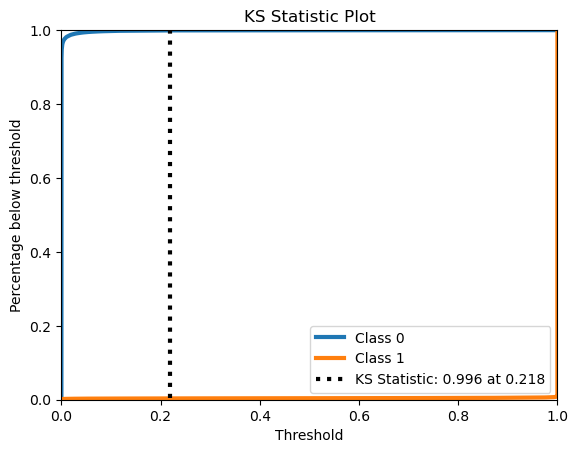

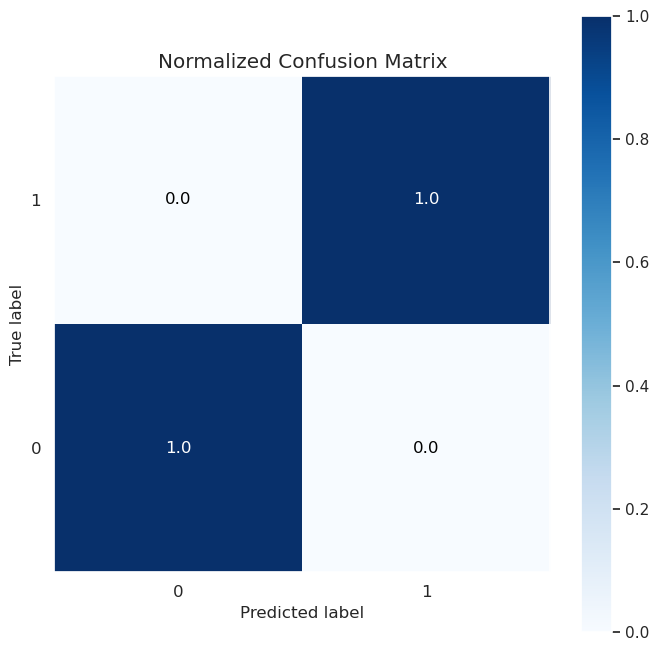

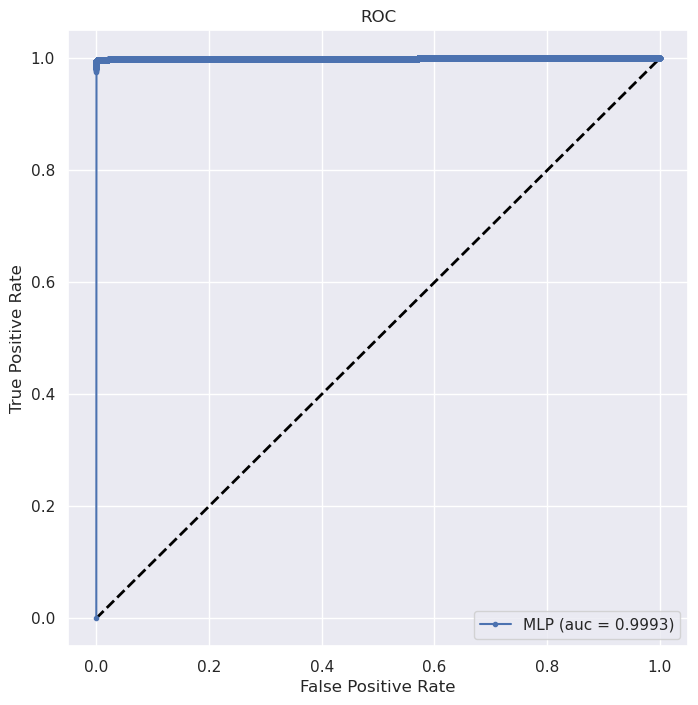

/home/pedro/projetoDL/log/exp_20241103170505/2_fold/


2024-11-20 15:50:49.007896: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 6364810496 exceeds 10% of free system memory.
2024-11-20 15:50:51.434190: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 6364810496 exceeds 10% of free system memory.


38970/38970 ━━━━━━━━━━━━━━━━━━━━ 39s 996us/step


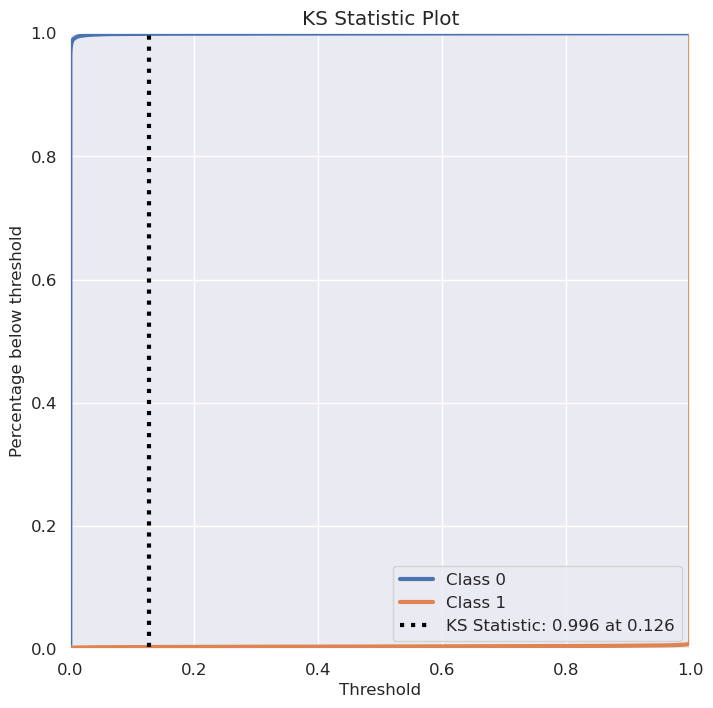

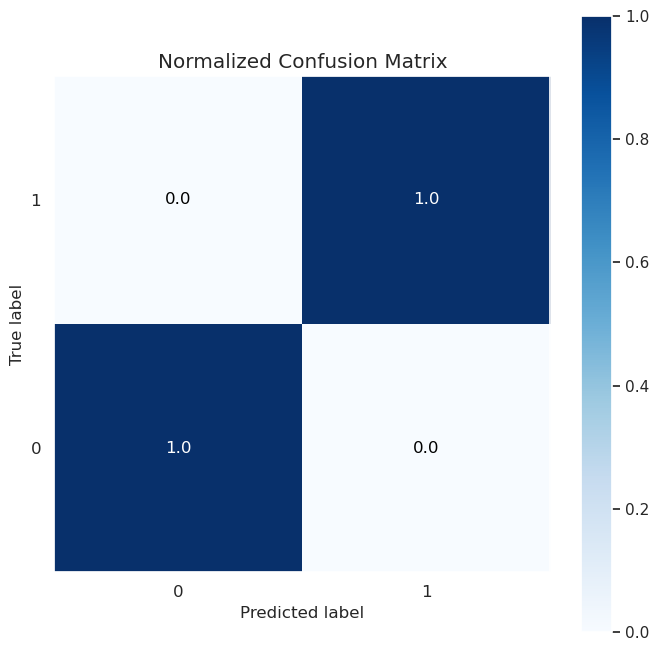

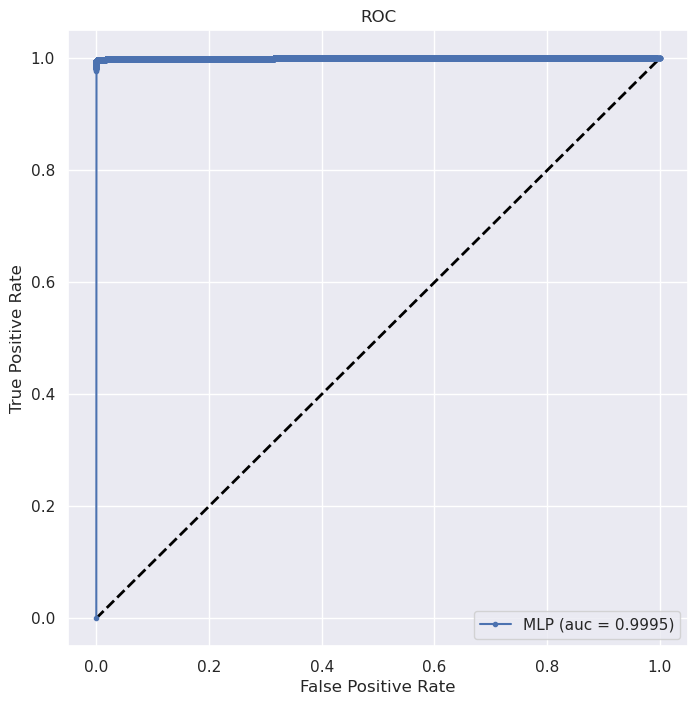

/home/pedro/projetoDL/log/exp_20241103170505/3_fold/


2024-11-20 15:51:45.024061: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 6364810496 exceeds 10% of free system memory.


38970/38970 ━━━━━━━━━━━━━━━━━━━━ 39s 991us/step


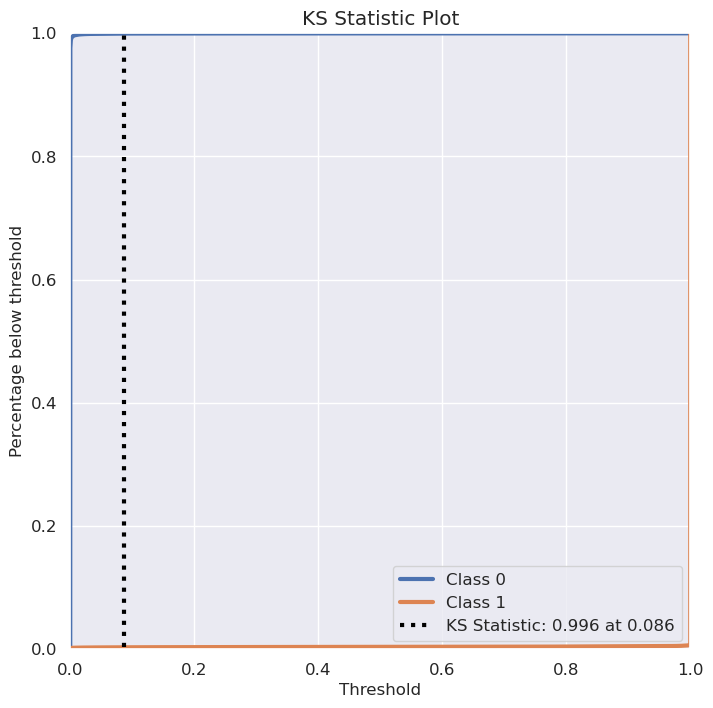

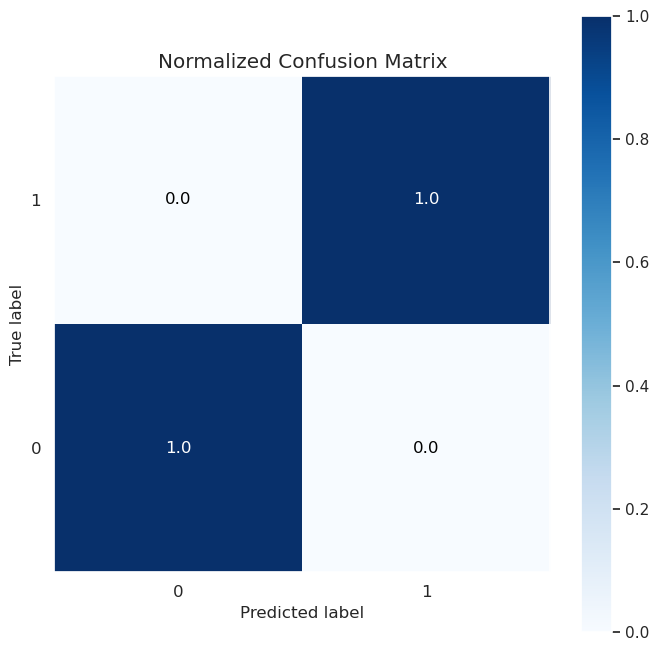

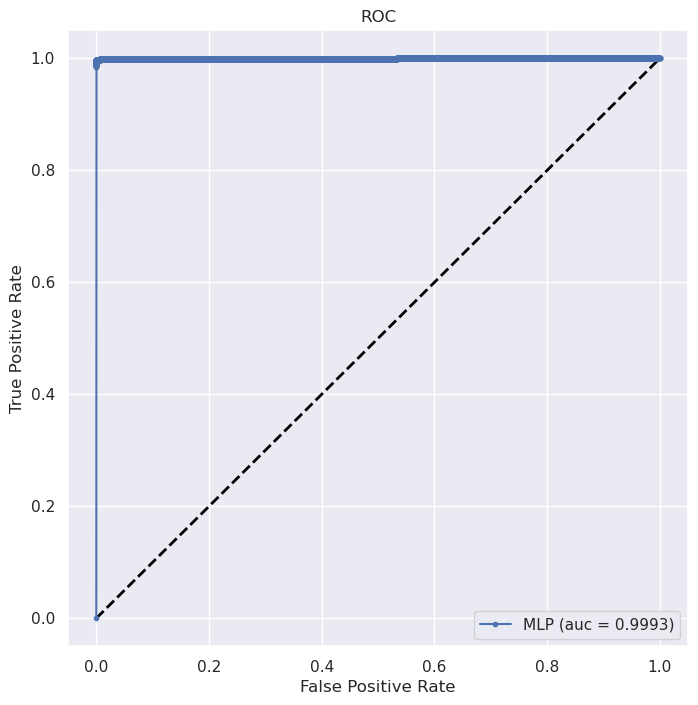

/home/pedro/projetoDL/log/exp_20241103170505/4_fold/
38970/38970 ━━━━━━━━━━━━━━━━━━━━ 38s 980us/step


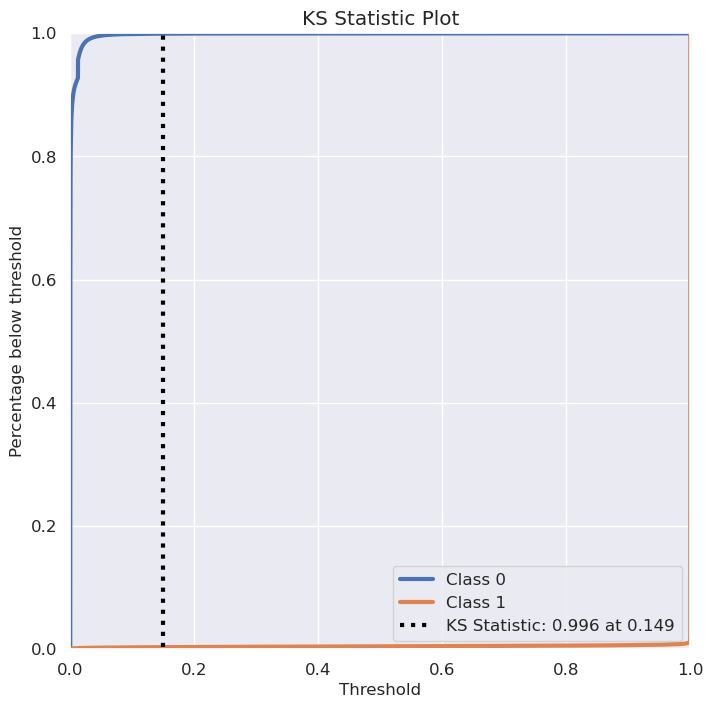

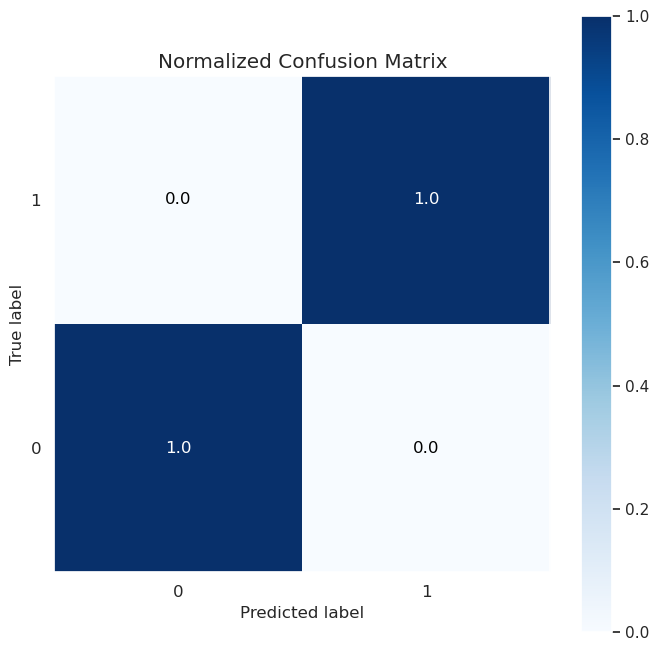

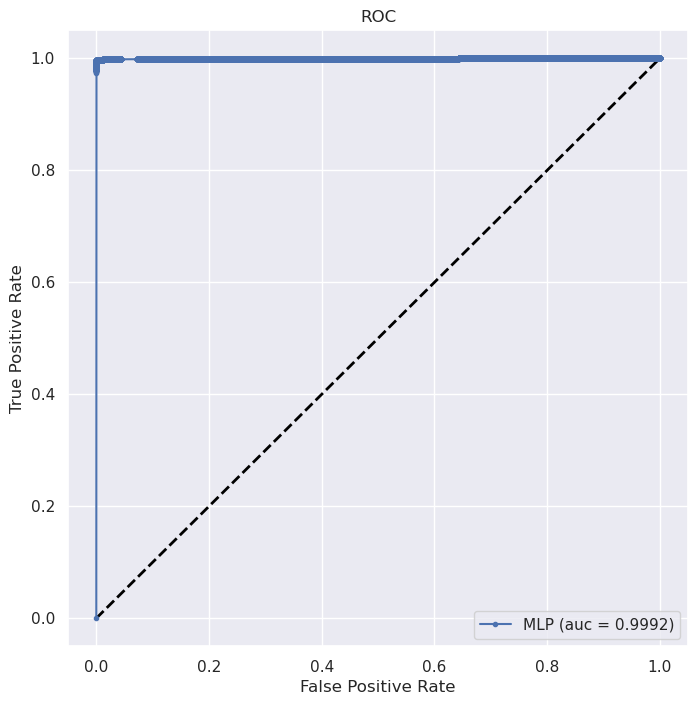

/home/pedro/projetoDL/log/exp_20241103170505/5_fold/
38970/38970 ━━━━━━━━━━━━━━━━━━━━ 39s 1ms/step


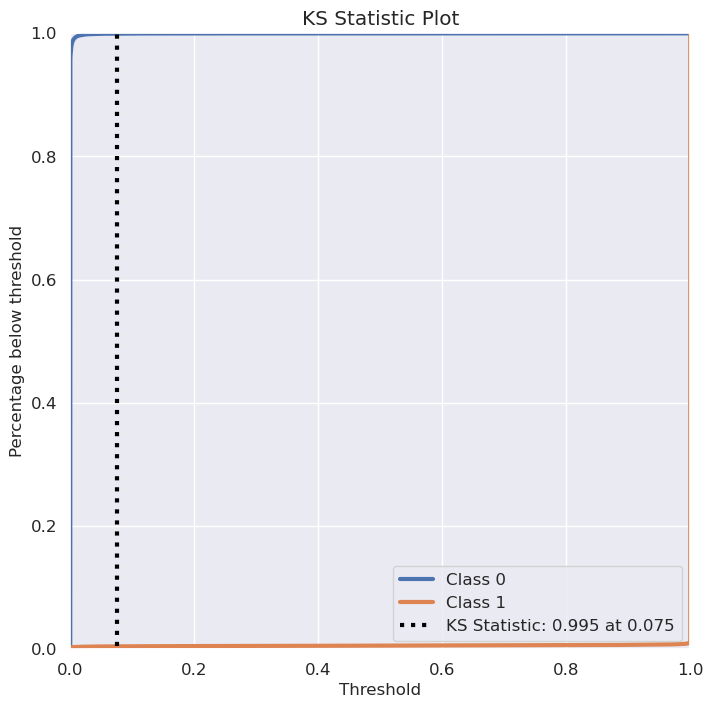

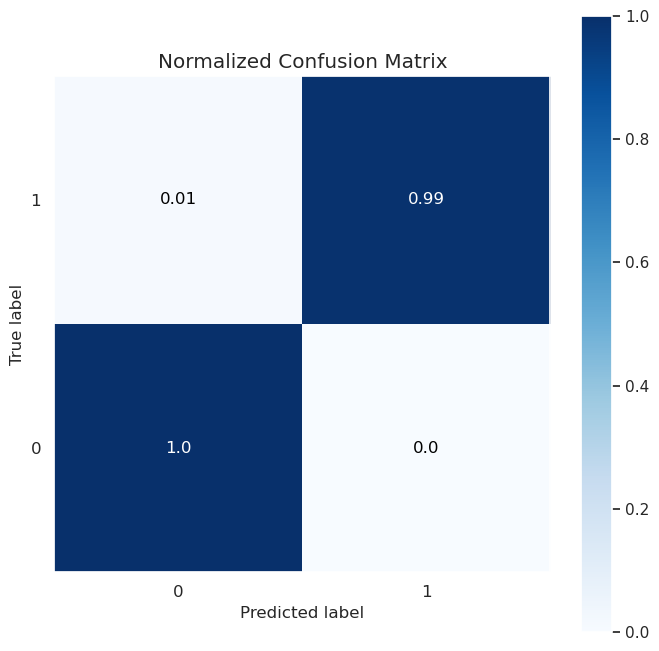

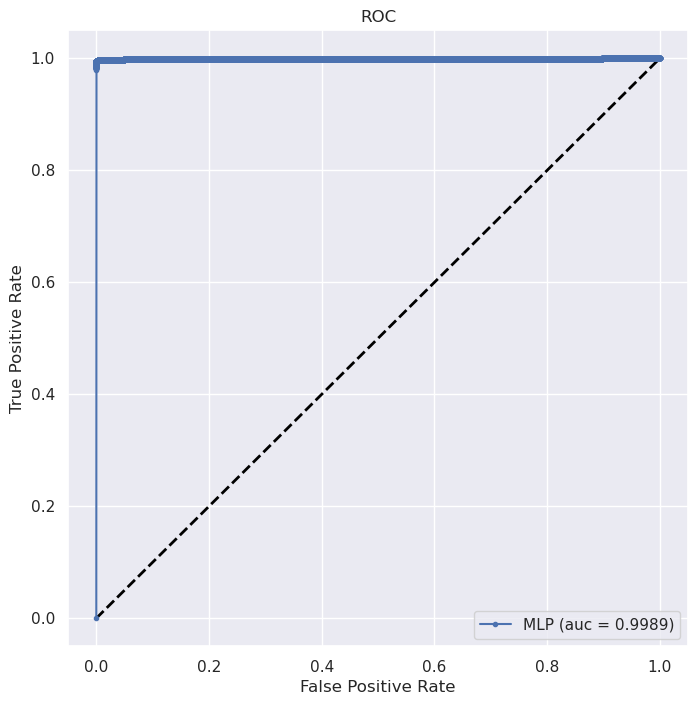

In [11]:
from keras.models import load_model
import time 
import os
import seaborn as sns

i = 1
tmp_path = '/home/pedro/projetoDL/log/exp_20241103170505/{}_fold/'
# tmp2_path = '/content/drive/MyDrive/Mestrado/automotivas/projeto/new_aproachs_data/results/CPU/fold'

for fold_no in [1,2,3,4,5]:
  load_path = tmp_path.format(fold_no)
  save_path = tmp_path.format(fold_no) + 'results/'
  print(load_path)

  # Verifica se o diretório existe, se não, cria o diretório
  if not os.path.exists(save_path):
      os.makedirs(save_path)

  file1 = open(save_path + 'TESTE_model_' + str(fold_no) + '_log.txt', "a")

  model = load_model(load_path + 'fold_n_' + str(fold_no) + '_2dconv_fixed.h5')

  start = time.time()
  y_pred_scores = model.predict(X)
  end = time.time()

  print(f"\nSubset size: 2/3\n", file=file1)

  print(f"Runtime of the program is {end - start}", file=file1)

  total_time = end - start
  timesample = total_time/y_pred_scores.shape[0]

  print(f"us/sample is {timesample*1000000}", file=file1)

  y_pred_class = (y_pred_scores > 0.5).astype("int64")

  y_pred_scores2 = y_pred_scores
  y_pred_scores_0 = 1 - y_pred_scores
  y_pred_scores = np.concatenate([y_pred_scores_0, y_pred_scores], axis=1)

  accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(Y, y_pred_class, y_pred_scores)
       
  print(f'Results for fold {fold_no}: Recall of {recall}; accuracy of {accuracy}; precision of {precision}; f1 of {f1}; auroc of {auroc}; aupr of {aupr}', file=file1)

  sns.set(rc={'figure.figsize':(8,8)})
  subplot = skplt.metrics.plot_confusion_matrix(Y, y_pred_class, normalize=True)
  subplot.set_ylim(-0.5, 1.5)
  plt.savefig(save_path + "conf_matrix_TESTE.png")
  plt.show()
  
  fpr_keras, tpr_keras, thresholds_keras = roc_curve(Y, y_pred_scores2)
  auc_keras = auc(fpr_keras, tpr_keras)

  sns.set(rc={'figure.figsize':(8,8)})
  plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
  plt.plot(fpr_keras, tpr_keras, marker='.', label='MLP (auc = %0.4f)' % auc_keras)
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC')
  plt.legend(loc="lower right")
  plt.savefig(save_path + "plot_roc_TESTE.png")
  plt.show()     

  file1.close()
  del model
  time.sleep(3)
  gc.collect()